## Rover Project Notebook - ND Student Elvis Shera
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

** Configure the Notebook plotting style. **

In [2]:
%matplotlib inline

** Import the necessary modules. **

In [3]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import scipy.misc                    # For saving images as needed
import glob                          # For reading in a list of images from a folder
import imageio
import pandas as pd
from moviepy.editor import ImageSequenceClip

** Read in and display a random image from the `training_dataset` folder. **

Total of 1042 images in the list.
channels = 3, rows = 160, columns = 320
min_val = 0, max_val = 255, mean_val = 122


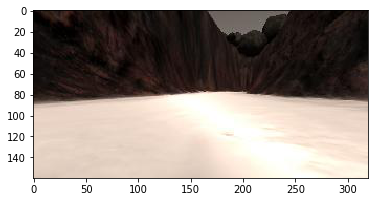

In [4]:
path = './training_dataset/IMG/*'

# make a list of the frames saved during training mode
img_list = glob.glob(path)
print("Total of %d images in the list."%(len(img_list)))

# Grab a random image from the list
idx = np.random.randint(0, len(img_list)-1)

# read in the picked immage
image = mpimg.imread(img_list[idx])

# print image size
print("channels = %d, rows = %d, columns = %d"%(image.shape[2], image.shape[0], image.shape[1]))

# print some statistic
print("min_val = %d, max_val = %d, mean_val = %d"%(image.min(), image.max(), image.mean()))

# show the image
plt.imshow(image)

# save the warped image
scipy.misc.imsave('./output/picked_example.jpg', image)

** Read in data for calibration. Display example grid and rock sample calibration images. Grid is needed for perspective transform and the rock image for creating a new color selection that identifies these samples so that can be picked up during autonomous navigation. **

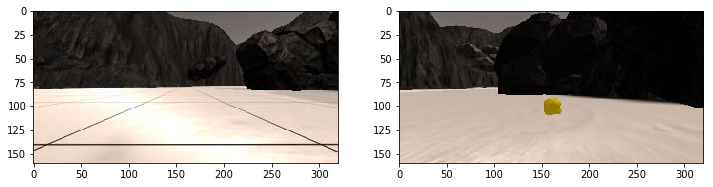

In [5]:
# pointer to image files
example_grid = './calibration_images/example_grid1.jpg'
example_rock = './calibration_images/example_rock1.jpg'

# load image from file pointer
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

# plot images
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

** Perspective Transform **

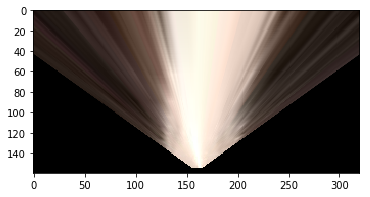

In [6]:
#==============================================================
# immage transformation
#==============================================================
def perspect_transform(img, src, dst):
    # get the transform function    
    M = cv2.getPerspectiveTransform(src, dst)
    # apply the transform to the input immage by keeping the same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])) 
    return warped



#==============================================================
# test code
#==============================================================
src = np.float32([[14, 140], [301 ,140], [200, 96], [118, 96]])

# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image is not the position of the rover but a bit in front of it
bottom_offset = 6

# identify the destination box
dst = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                          [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                        ])

# create warp immage and related mask
warped = perspect_transform(image, src, dst)

# save the warped image
scipy.misc.imsave('./output/warped_example.jpg', warped)

fig = plt.figure(figsize=(12,3))
plt.imshow(warped)

** Filtering Functions for Obstacles, Rocks & Navigation terrain **

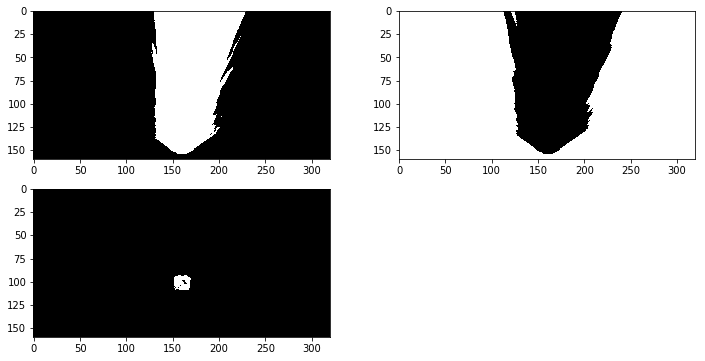

In [7]:
#==============================================================
# select navigable terrain
#==============================================================
def find_navigable(img, rgb_thresh=(160, 160, 160)):
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                 & (img[:,:,1] > rgb_thresh[1]) \
                 & (img[:,:,2] > rgb_thresh[2])
    
    color_select = np.zeros_like(img[:,:,0])    
    color_select[above_thresh] = 1
    return color_select


#==============================================================
# find rocks
#==============================================================
def find_rocks(img, levels=(110, 110, 50)):
    rockpix =     (img[:,:,0] > levels[0]) \
                & (img[:,:,1] > levels[1]) \
                & (img[:,:,2] < levels[2])

    color_select = np.zeros_like(img[:,:,0])
    color_select[rockpix] = 1
    return color_select

#==============================================================
# find obstacles
#==============================================================
def find_obstacles(img, rgb_thresh=(130, 130, 130)):
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    
    color_select = np.zeros_like(img[:,:,0])
    color_select[below_thresh] = 1
    return color_select

#==============================================================
# test code
#==============================================================
rock_map  = find_rocks(rock_img)
nav_map   = find_navigable(warped)
obst_map  = find_obstacles(warped)

scipy.misc.imsave('./output/rock_map.jpg', rock_map*255)
scipy.misc.imsave('./output/nav_map.jpg', nav_map*255)
scipy.misc.imsave('./output/obst_map.jpg', obst_map*255)

fig = plt.figure(figsize=(12,6))
plt.subplot(221)
plt.imshow(nav_map, cmap='gray')
plt.subplot(222)
plt.imshow(obst_map, cmap='gray')
plt.subplot(223)
plt.imshow(rock_map, cmap='gray')

** Coordintate Transformations **

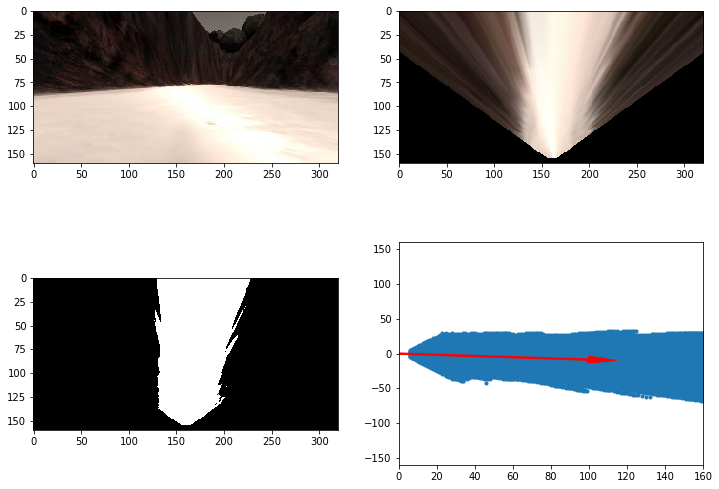

In [8]:
#==============================================================
# Define a function to convert from image coords to rover coords
#==============================================================
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


#==============================================================
# Define a function to convert to radial coords in rover space
#==============================================================
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

#==============================================================
# Define a function to map rover space pixels to world space
#==============================================================
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

#==============================================================
# Define function to translate coordinates
#==============================================================
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

#==============================================================
# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
#==============================================================
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world




#==============================================================
# test the code
#==============================================================
# Calculate pixel values in rover-centric coords. Since the thresh is in black and white, the trasformation will be on all the 
# pixesls in the white part. The returning valuea are 2 array x,y of all the pixels in white.... or highliting the navigable part.
xpix, ypix = rover_coords(nav_map)

# calculate distance/angle to all pixels. pixels are give as 2 arrays x,y.  
dist, angles = to_polar_coords(xpix, ypix)

# calculate mean angle from the set of angles. This correspondes to move in the meadle of the navigable terrain.
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)

plt.subplot(222)
plt.imshow(warped)

plt.subplot(223)
plt.imshow(nav_map, cmap='gray')

plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)

# draw an vector to indicate direction into the picture
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

** Read training dataset in pandas dataframe. **

In [9]:
# create data frame
df = pd.read_csv('./training_dataset/robot_log.csv', delimiter=';', decimal=',')      

# check some results
df.head()

,Path,SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll
0,./training_dataset/IMG/robocam_2017_12_03_21_1...,0,0,1,0,99.66998,85.58897,0.0002325676,51.37635,-2.057441E-07
1,./training_dataset/IMG/robocam_2017_12_03_21_1...,0,0,0,0,99.66998,85.58897,0.0002327037,51.37635,-2.71162E-07
2,./training_dataset/IMG/robocam_2017_12_03_21_1...,0,0,0,0,99.66998,85.58897,0.000232739,51.37635,-3.718779E-07
3,./training_dataset/IMG/robocam_2017_12_03_21_1...,0,0,0,0,99.66998,85.58897,0.0002330587,51.37635,-3.163545E-07
4,./training_dataset/IMG/robocam_2017_12_03_21_1...,0,0,0,0,99.66998,85.58897,0.0002332301,51.37635,-4.824949E-07


** Read in ground truth map and create a 3-channel image with it. **

(200, 200)


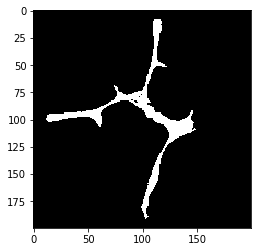

In [10]:
ground_truth = mpimg.imread('./calibration_images/map_bw.png')
print(ground_truth.shape)
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

plt.imshow(ground_truth, cmap='gray')

** Create a data bucket **

In [11]:
#==============================================================
# DataBucket class
#==============================================================
class Databucket():
    def __init__(self):
        # replacing some colums with float values
        df['X_Position']  = df['X_Position'].replace('%','',regex=True).astype('float')/100
        df['Y_Position']  = df['Y_Position'].replace('%','',regex=True).astype('float')/100
        df['Yaw']         = df['Yaw'].replace('%','',regex=True).astype('float')/100
        self.images       = df["Path"].tolist()
        self.xpos         = df["X_Position"].values
        self.ypos         = df["Y_Position"].values
        self.yaw          = df["Yaw"].values
        self.speed        = df["Speed"].values
        self.pitch        = df["Pitch"].values
        self.brake        = df["Brake"].values
        self.throttle     = df["Throttle"].values
        self.count        = -1 # This will be a running index, -1 becasue the movie does an extra itteration leading to index error
        self.worldmap     = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap


# Create data object (Databucket) containing the training frames
data = Databucket()

** create a function to process the image list **

In [12]:
def process_image(img):
    #======================================================================
    # get current x, y and yaw values from the CSV file
    #======================================================================
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw  = data.yaw[data.count]
    
    
    #======================================================================
    # Apply perspective transform
    #======================================================================
    warped = perspect_transform(img, src, dst)

    #======================================================================
    # Get the maps for the navigable terrain, obstacles and the rock
    #======================================================================
    rock_map  = find_rocks(warped)
    nav_map   = find_navigable(warped)
    obst_map  = find_obstacles(warped)

    #======================================================================
    # Coordinate transformations 
    #======================================================================
    world_size = data.worldmap.shape[0]
    scale = dst_size * 2
    
    # navigable terrain
    xpix_nav, ypix_nav = rover_coords(nav_map)    
    distances_nav, angles_nav = to_polar_coords(xpix_nav, ypix_nav) # Convert to polar coords, calculate distances and angles of navigable terrain
    avg_angle_nav = np.mean(angles_nav) # Compute the average angle. This helps in setting the direction of robot
    x_world_nav, y_world_nav = pix_to_world(xpix_nav, ypix_nav, xpos, ypos, yaw, world_size, scale)


    # obstacles
    xpix_obst, ypix_obst = rover_coords(obst_map)
    distances_obst, angles_obst = to_polar_coords(xpix_obst, ypix_obst)
    x_world_obst, y_world_obst = pix_to_world(xpix_obst, ypix_obst, xpos, ypos, yaw, world_size, scale)


    # rocks
    min_dist_rock  = 0.0
    avg_angle_rock = 0.0
    if rock_map.any():
        xpix_rock, ypix_rock = rover_coords(rock_map) 
        distances_rock, angles_rock = to_polar_coords(xpix_rock, ypix_rock)
        avg_angle_rock = np.mean(angles_rock)
        min_dist_rock  = np.min(distances_rock)
        x_world_rock, y_world_rock = pix_to_world(xpix_rock, ypix_rock, xpos, ypos, yaw, world_size, scale)


    #======================================================================
    # Update the worldmap with the image analysis
    #======================================================================    
    # navigable area in the blue channel of the worldmap
    data.worldmap[y_world_nav, x_world_nav, 2] = 255
    
    # obstacles placed in the red channel
    data.worldmap[y_world_obst, x_world_obst, 0] = 255

    # rocks placed in the green channel
    if rock_map.any():
        data.worldmap[y_world_rock, x_world_rock, 1] = 255

    #======================================================================   
    # Overlay obstacle and navigable terrain map with ground truth map
    #======================================================================
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
     
    #======================================================================
    # add telemetric data
    #======================================================================
    # create a black bacground map
    telemap = np.zeros([200,440,3], np.uint8)
    cv2.putText(telemap,"Telemetry:",                                                (150, 20),  cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('xpos:', str(xpos)),                             (160, 40),  cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('ypos:', str(ypos)),                             (160, 55),  cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('Yaw:', str(yaw)),                               (160, 70),  cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('Speed:', str(data.speed[data.count])),          (160, 85),  cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('Brake:', str(data.brake[data.count])),          (160, 100), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('Throttle:', str(data.throttle[data.count])),    (160, 115), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('Pitch:', str(data.pitch[data.count])),          (160, 130), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('distance to rock:', str(min_dist_rock)),        (160, 145), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(telemap,"%-23s %s"%('angle to rock:', str(avg_angle_rock)),          (160, 160), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)


    #======================================================================
    # Create an output immage for the movie
    #======================================================================

    # Create a blank image as an array of  x, y, 3. the number 3 referes as 3 layers of color (R,G,B)
    output_image = np.zeros((img.shape[0] + world_size, img.shape[1]*2, 3))

    # original camera image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    # warped images to the upper right corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # worldmap to the lower left corner
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = map_add

    # Telemetry to the lower right corner
    output_image[img.shape[0]:, data.worldmap.shape[1]:] = telemap

    # Then putting some text over the image
    cv2.putText(output_image,"ND Student - Elvis Shera!", (10, 10), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket(), the loop is create from the moviewpy call to the function 
    return output_image

** Make a video from processed image data. **  

In [13]:
# create a clip from a list of images in the Databucket
clip = ImageSequenceClip(data.images, fps=60) 

#  clip.fl_image does nota ccept extra arguments
new_clip = clip.fl_image(process_image)

# Define pathname to save the output video
output = './output/training_mapping.mp4'
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output/training_mapping.mp4
[MoviePy] Writing video ./output/training_mapping.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:10<00:00, 99.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/training_mapping.mp4 

Wall time: 10.6 s


** inline video player **

In [14]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))